This is the highest accuracy so far, slightly more than 60% accuracy.

I played around with the alpha and beta values a bit:

- The accuracy against beta curve has a very characteristic shape. You'll get this shape for all combinations of alpha, beta, and item value difference.

- It seems like the optimal beta value is always roughly around 7 to 8, which is just nice 0.8 times the value difference between the high value item and the low value item. I suspect I can come up with an empirical formula for the optimal beta in terms of the $\Delta$ energy difference between ground and first excited state.

- It seems like the value of alpha doesnt matter anymore beyond a certain magnitude of alpha. With alpha greater than 1e2, the maximum accuracy (even with the optimal beta) starts to drop (but not by a lot. Given some large alpha, the maximum accuracy for the optimal beta is always around 0.55 - 0.6).

I also tried increasing the value gap between the 2 items. For example, item1 I give value of 100, item2 I give value of 1. It doesn't seem to affect the accuracy. It just shifts the optimal beta up to about 800.

In [26]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

In [27]:
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)

In [28]:
Values = [10, 1]
Weights = [2, 3]
Ancil = [1, 2]

alpha = 1e2
beta = 7.13
gamma = max(Values) + 1
T = 1
t_axis = np.arange(0, T, 0.01)

In [29]:
sigmaI = np.array(
    [
        [1, 0],
        [0, 1],
    ]
)
sigmaX = np.array(
    [
        [0, 1],
        [1, 0],
    ]
)
sigmaBin = np.array(
    [
        [0, 0],
        [0, 1],
    ]
)

In [30]:
# H0 = np.zeros((2**(len(Values) + len(Ancil)), 2**(len(Values) + len(Ancil))))
H0 = np.kron(np.kron(np.kron(sigmaX, sigmaI), sigmaI), sigmaI) + np.kron(np.kron(np.kron(sigmaI, sigmaX), sigmaI), sigmaI) + np.kron(np.kron(np.kron(sigmaI, sigmaI), sigmaX), sigmaI) + np.kron(np.kron(np.kron(sigmaI, sigmaI), sigmaI), sigmaX)
# print(H0)

eigenvals_H0, eigenvecs_H0 = np.linalg.eigh(H0)
ground_idx_H0 = eigenvals_H0.argsort()[0]
print(eigenvals_H0[ground_idx_H0])
print(eigenvecs_H0[:, ground_idx_H0])

-4.000000000000003
[ 0.25 -0.25 -0.25  0.25 -0.25  0.25  0.25 -0.25 -0.25  0.25  0.25 -0.25
  0.25 -0.25 -0.25  0.25]


In [31]:
Hp = (
    - (Values[0] * np.kron(np.kron(np.kron(sigmaBin, sigmaI), sigmaI), sigmaI) + Values[1] * np.kron(np.kron(np.kron(sigmaI, sigmaBin), sigmaI), sigmaI))
    + gamma * (
        (Weights[0] * np.kron(np.kron(np.kron(sigmaBin, sigmaI), sigmaI), sigmaI) + Weights[1] * np.kron(np.kron(np.kron(sigmaI, sigmaBin), sigmaI), sigmaI))
      - (Ancil[0] * np.kron(np.kron(np.kron(sigmaI, sigmaI), sigmaBin), sigmaI) + Ancil[1] * np.kron(np.kron(np.kron(sigmaI, sigmaI), sigmaI), sigmaBin))
    )**2
)
# print(Hp)

eigenvals_Hp, eigenvecs_Hp = np.linalg.eigh(Hp)
ground_idx_Hp = eigenvals_Hp.argsort()[0]
print(eigenvals_Hp[ground_idx_Hp])
print(eigenvecs_Hp[:, ground_idx_Hp])


-10.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [32]:
def H(t):
    return alpha * ( (1 - t/T)*beta*H0 + (t/T)*Hp )

# print(H(0))
# print(H(T))

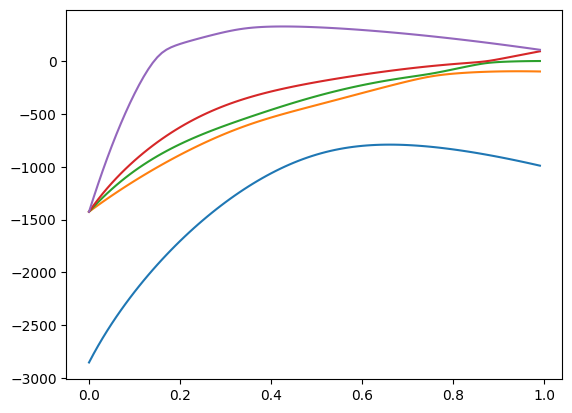

In [33]:
instant_eigenvals = []
for t in t_axis:
    eigenvals, eigenvecs = np.linalg.eigh(H(t))
    instant_eigenvals.append(eigenvals[eigenvals.argsort()[0:5]])

# print(instant_eigenvals)
plt.plot(t_axis, instant_eigenvals)

In [34]:
int_H_T = 0.5 * alpha * T * (beta*H0 + Hp)

In [35]:
U = expm(-1j * int_H_T)
# print(U.conjugate().transpose() @ U)

In [36]:
psi_ini = eigenvecs_H0[:, ground_idx_H0]
print(psi_ini)
print(np.linalg.norm(psi_ini))

[ 0.25 -0.25 -0.25  0.25 -0.25  0.25  0.25 -0.25 -0.25  0.25  0.25 -0.25
  0.25 -0.25 -0.25  0.25]
1.0000000000000004


In [37]:
psi_final = U @ psi_ini
print(psi_final)
print(np.linalg.norm(psi_final))

[-0.064+0.027j -0.02 -0.074j -0.042-0.125j -0.002+0.117j -0.23 +0.129j
 -0.027+0.061j  0.167+0.098j  0.   -0.022j -0.094-0.028j  0.185-0.76j
 -0.006+0.012j -0.077+0.242j -0.163-0.092j  0.127-0.045j -0.12 -0.23j
  0.191+0.062j]
0.9999999999998365


In [38]:
psi_correct = eigenvecs_Hp[:, ground_idx_Hp]
print(psi_correct)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [39]:
def int_H(t):
    return 0.5 * alpha * t / T * (2 * beta * H0*T + (-beta * H0 + Hp)*t )

def Unitary(t):
    return expm(-1j * int_H(t))

In [40]:
int_H(T) - int_H_T

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [41]:
int_H(T)

array([[    0. ,   356.5,   356.5,     0. ,   356.5,     0. ,     0. ,
            0. ,   356.5,     0. ,     0. ,     0. ,     0. ,     0. ,
            0. ,     0. ],
       [  356.5,  2200. ,     0. ,   356.5,     0. ,   356.5,     0. ,
            0. ,     0. ,   356.5,     0. ,     0. ,     0. ,     0. ,
            0. ,     0. ],
       [  356.5,     0. ,   550. ,   356.5,     0. ,     0. ,   356.5,
            0. ,     0. ,     0. ,   356.5,     0. ,     0. ,     0. ,
            0. ,     0. ],
       [    0. ,   356.5,   356.5,  4950. ,     0. ,     0. ,     0. ,
          356.5,     0. ,     0. ,     0. ,   356.5,     0. ,     0. ,
            0. ,     0. ],
       [  356.5,     0. ,     0. ,     0. ,  4900. ,   356.5,   356.5,
            0. ,     0. ,     0. ,     0. ,     0. ,   356.5,     0. ,
            0. ,     0. ],
       [    0. ,   356.5,     0. ,     0. ,   356.5,   500. ,     0. ,
          356.5,     0. ,     0. ,     0. ,     0. ,     0. ,   356.5,
            0

In [42]:
H(T)

array([[    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.],
       [    0.,  4400.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.],
       [    0.,     0.,  1100.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.],
       [    0.,     0.,     0.,  9900.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.],
       [    0.,     0.,     0.,     0.,  9800.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.],
       [    0.,     0.,     0.,     0.,     0.,  1000.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.],
       [    0.,     0.,     0.,     0.,     0.,     0.,  4300.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,   

In [43]:
Unitary(T)

array([[ 0.003-0.129j,  0.049+0.216j,  0.178+0.226j, -0.03 +0.049j,
         0.066-0.03j , -0.14 +0.074j, -0.025-0.002j,  0.078-0.441j,
         0.07 +0.201j, -0.042-0.5j  ,  0.204+0.233j, -0.204-0.391j,
        -0.007-0.006j,  0.016+0.015j, -0.009-0.016j,  0.024+0.168j],
       [ 0.049+0.216j,  0.204+0.879j,  0.026-0.034j, -0.073+0.006j,
        -0.034-0.01j ,  0.142+0.105j,  0.023-0.032j,  0.066-0.041j,
        -0.104-0.01j , -0.021+0.261j, -0.036-0.065j,  0.028+0.024j,
         0.005+0.001j, -0.035-0.035j,  0.001+0.006j, -0.017-0.012j],
       [ 0.178+0.226j,  0.026-0.034j,  0.456+0.602j, -0.054+0.018j,
        -0.019+0.013j, -0.257-0.149j,  0.138-0.123j, -0.243+0.289j,
        -0.037-0.082j, -0.025+0.189j,  0.088+0.085j,  0.072-0.093j,
         0.001+0.001j,  0.026+0.004j, -0.013+0.006j,  0.032-0.041j],
       [-0.03 +0.049j, -0.073+0.006j, -0.054+0.018j, -0.228+0.895j,
        -0.198+0.262j,  0.012+0.007j, -0.073+0.06j , -0.023+0.061j,
         0.008+0.004j,  0.008-0.073j, -0.028-

In [44]:
Unitary(T).conjugate().transpose() @ Unitary(T)

array([[ 1.-0.j,  0.+0.j, -0.+0.j,  0.-0.j,  0.+0.j,  0.-0.j,  0.+0.j,
        -0.+0.j, -0.+0.j, -0.+0.j,  0.-0.j, -0.+0.j, -0.+0.j,  0.-0.j,
        -0.+0.j,  0.-0.j],
       [ 0.-0.j,  1.+0.j, -0.+0.j,  0.-0.j,  0.+0.j, -0.-0.j,  0.-0.j,
        -0.+0.j,  0.+0.j, -0.-0.j, -0.-0.j,  0.+0.j, -0.-0.j, -0.+0.j,
        -0.+0.j,  0.-0.j],
       [-0.-0.j, -0.-0.j,  1.+0.j,  0.+0.j, -0.+0.j,  0.+0.j,  0.+0.j,
         0.-0.j,  0.-0.j, -0.+0.j, -0.+0.j,  0.-0.j, -0.+0.j, -0.+0.j,
        -0.-0.j, -0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.-0.j,  1.+0.j, -0.+0.j, -0.+0.j, -0.+0.j,
         0.-0.j, -0.-0.j,  0.+0.j,  0.-0.j,  0.-0.j, -0.+0.j,  0.+0.j,
        -0.-0.j,  0.-0.j],
       [ 0.-0.j,  0.-0.j, -0.-0.j, -0.-0.j,  1.+0.j,  0.-0.j,  0.-0.j,
        -0.-0.j, -0.-0.j,  0.+0.j, -0.-0.j,  0.-0.j, -0.-0.j,  0.-0.j,
        -0.+0.j,  0.-0.j],
       [ 0.+0.j, -0.+0.j,  0.-0.j, -0.-0.j,  0.+0.j,  1.+0.j, -0.+0.j,
         0.+0.j,  0.-0.j, -0.-0.j,  0.+0.j, -0.+0.j, -0.-0.j, -0.+0.j,
        -0.-0

In [45]:
psi_ini = eigenvecs_H0[:, ground_idx_H0]
# print(psi_ini)
# print(np.linalg.norm(psi_ini))

psi_correct = eigenvecs_Hp[:, ground_idx_Hp]
# print(psi_correct)

# psi_t_list = []
energy_expectation_t_list = []
psi_t_list = []

for t in t_axis:
    psi_t = Unitary(t) @ psi_ini
    # print(psi_t)
    # print(np.linalg.norm(psi_t))
    energy_expectation_t_list.append(psi_t.conjugate().transpose() @ H(t) @ psi_t)
    psi_t_list.append(psi_t)

print(energy_expectation_t_list)
for psi_t in psi_t_list:
    print(psi_t, sep="\n")

[np.complex128(-2852.000000000002+0j), np.complex128(-2770.37790574789-2.842170943040401e-14j), np.complex128(-2690.12291641348+1.1368683772161603e-13j), np.complex128(-2605.8243333336886+0j), np.complex128(-2529.2481664308616+0j), np.complex128(-2458.8987325106505+0j), np.complex128(-2360.980123690437+5.684341886080802e-14j), np.complex128(-2284.9726933449165-5.684341886080802e-14j), np.complex128(-2260.5102530786244+4.263256414560601e-14j), np.complex128(-2162.327208606366-5.684341886080802e-14j), np.complex128(-2117.211435090029+0j), np.complex128(-1997.1960187882883-1.1368683772161603e-13j), np.complex128(-1996.8804281684806-2.842170943040401e-14j), np.complex128(-1821.517130847353+0j), np.complex128(-1823.6235914272752+0j), np.complex128(-1835.783819684763+0j), np.complex128(-1748.290369375364+1.4210854715202004e-14j), np.complex128(-1687.1156172430374+0j), np.complex128(-1508.6321240950774+5.684341886080802e-14j), np.complex128(-1409.5762701614226+0j), np.complex128(-1509.2401958

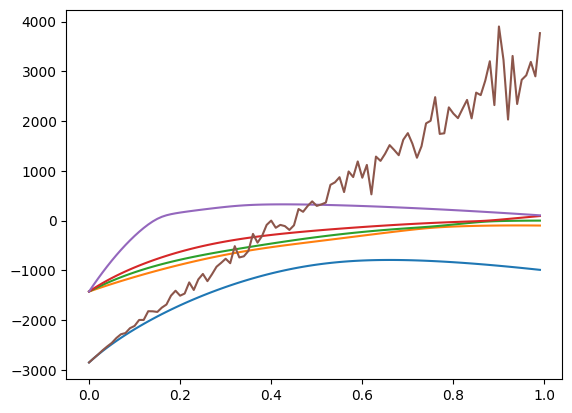

In [46]:
instant_eigenvals = []

for t in t_axis:
    eigenvals, eigenvecs = np.linalg.eigh(H(t))
    instant_eigenvals.append(eigenvals[eigenvals.argsort()[0:5]])

# print(instant_eigenvals)
plt.plot(t_axis, instant_eigenvals)
plt.plot(t_axis, energy_expectation_t_list)

In [47]:
accuracy_list = []
beta_list = np.arange(0, 100, 0.01)

for beta in beta_list:
    int_H_T = 0.5 * alpha * T * (beta*H0 + Hp)
    U = expm(-1j * int_H_T)

    psi_final = U @ psi_ini
    # print(psi_final)
    # print(psi_final.conjugate().transpose() @ psi_final)
    accuracy = np.abs(np.dot(psi_correct, psi_final))**2
    # print(accuracy)
    accuracy_list.append(accuracy)
    
accuracy_list = np.array(accuracy_list)

Text(0, 0.5, 'accuracy')

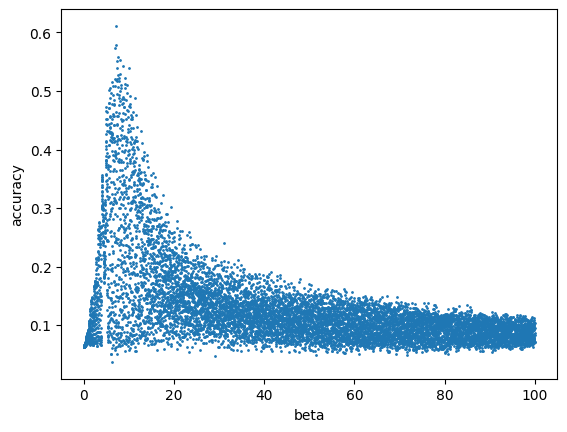

In [48]:
plt.scatter(beta_list, accuracy_list, s=1)
plt.xlabel("beta")
plt.ylabel("accuracy")

In [49]:
max(accuracy_list)

np.float64(0.6111562319914219)

In [50]:
beta_list[accuracy_list.argmax()]

np.float64(7.13)